# 0. Data loading and cleaning

In [1]:
import json
import jsonlines
import glob
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime

In [2]:
DATA_TX = "dht_txns.json"       # All file transactions
DATA_GOSSIP = "dht_gossip.json" # All peer gossip
DATA_TS = "dht_timeseries.json" # All events, summarized

def hostnameToLocation(hostname): 
    """VP hostname to location code."""
    
    label = hostname.split(".")[0] 
    locationCode = label.split("-")[-1] if hostname != "fruchter-ipfs-probe" else "chs1"
    return locationCode

def jsonTimestampToDatetime(ts):
    """Convert MongoDB JSON timestamps to datetime-readable ISO."""
    return datetime.fromisoformat( ts.replace("Z", "") )

# Load DHT file transaction data from its MongoDB JSON export 
with open(DATA_TX) as f:
    txns = [json.loads(line) for line in f.readlines()]
    for tx in tqdm(txns):
        # Remove Mongo ID
        del tx['_id']

        # Parse hostname        
        location = hostnameToLocation(tx['VANTAGE'])
        tx['VANTAGE'] = location
        tx['VP_SHORT'] = location[0:3]
        
        # Timestamp to Python datetime
        tx['TIMESTAMP'] = jsonTimestampToDatetime(tx['TIMESTAMP']['$date'])
        
# Load DHT peer gossip data      
with open(DATA_GOSSIP) as f:
    gossip = [json.loads(line) for line in tqdm(f.readlines())]
    for tx in tqdm(gossip):
        # Remove Mongo ID
        del tx['_id']

        # Extract peers
        peers = [ peer['Fields'] for peer in tx['Logs'] if len(peer['Fields']) ]
        if peers: 
            peer = peers[0][0]['Value'].split(" ")[1][0:-1]
            target = peers[1][0]['Value'].split(" ")[1][0:-1]
            
        tx['Peer'] = peer
        tx['Target'] = target
        
        # Parse hostname        
        location = hostnameToLocation(tx['VANTAGE'])
        tx['VANTAGE'] = location
        tx['VP_SHORT'] = location[0:3]

        # Timestamp to Python datetime
        tx['TIMESTAMP'] = jsonTimestampToDatetime(tx['TIMESTAMP']['$date'])
        del tx['Logs']

# Load minimal representation of all DHT events 
with open(DATA_TS) as f:
    timeseries = [json.loads(line) for line in f.readlines()]
    for tx in tqdm(timeseries):
        # Remove Mongo ID
        del tx['_id']

        # Parse hostname        
        location = hostnameToLocation(tx['VANTAGE'])
        tx['VANTAGE'] = location
        tx['VP_SHORT'] = location[0:3]
        
        # Timestamp to Python datetime
        tx['TIMESTAMP'] = jsonTimestampToDatetime(tx['TIMESTAMP']['$date'])
        
        if type(tx['Duration']) == dict: 
            tx['Duration'] = int(tx['Duration']['$numberLong'] )

100%|██████████| 1792695/1792695 [00:06<00:00, 273805.72it/s]


In [3]:
# Create pandas dataframes
dfTxns = pd.DataFrame(txns)
dfGossip = pd.DataFrame(gossip)

dfTimeseries = pd.DataFrame(timeseries)
dfTimeseries['dti'] = pd.DatetimeIndex(dfTimeseries['TIMESTAMP'])
dfTimeseries.index = dfTimeseries.dti

# 1. Timeseries of activity by time of day

In [4]:
# A. Ops density by hour

# Categorize DHT events by type
opsLabels = {
    "FindPeer": "routing",
    "Provide": "providing",
    "PutValue": "fetching",
    "findPeerSingle": "routing",
    "getClosestPeers": "routing",
    "handleAddProvider": "providing",
    "handleFindPeer": "routing",
    "handleGetProviders": "fetching",
    "handleGetValue": "fetching",
    "handlePutValue": "fetching"    
}
dfTimeseries['OpCategory'] = dfTimeseries['Operation'].map(opsLabels)
ops_by_hour = dfTimeseries.groupby([dfTimeseries.index.hour, 'OpCategory', 'VP_SHORT'])['OpCategory'].size().rename('count').reset_index()

# Map location code to region code
region = {'lax': 'na', 'chs1': 'na', 'chs2': 'na', 'ams': 'eu', 'ams2': 'eu', 'hel': 'eu', 'bom': 'ap', 'sin': 'ap', 'gru': 'sa'}
dfTimeseries['Region'] = dfTimeseries.VANTAGE.map(region)



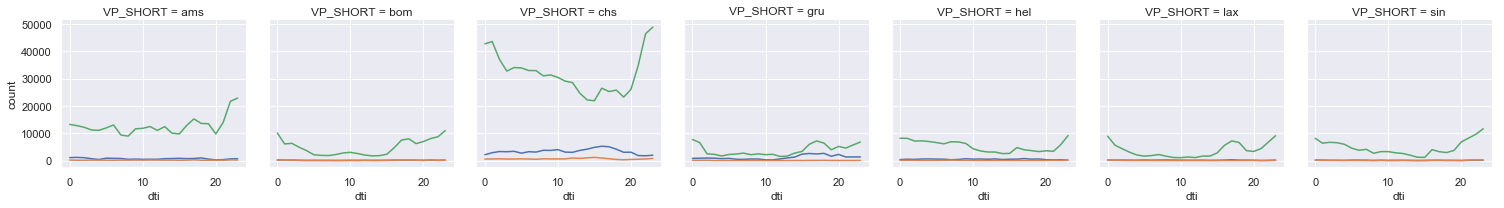

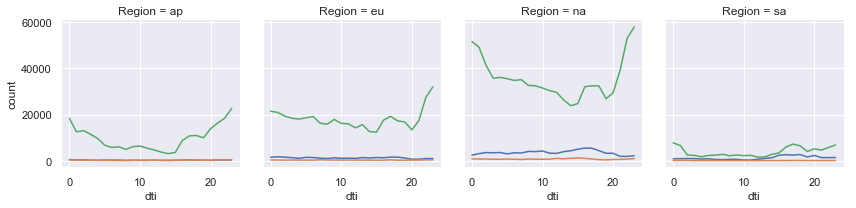

In [5]:
# By VP
ops_by_hour_vantage = dfTimeseries.groupby(
    [dfTimeseries.index.hour, 'OpCategory', 'VP_SHORT']
)['OpCategory'].size().rename('count').reset_index()

g = sns.FacetGrid(data=ops_by_hour_vantage, col='VP_SHORT',  hue='OpCategory')
g.map(sns.lineplot, 'dti', 'count')


# By region
ops_by_hour_region = dfTimeseries.groupby(
    [dfTimeseries.index.hour, 'OpCategory', 'Region']
)['OpCategory'].size().rename('count').reset_index()

g = sns.FacetGrid(data=ops_by_hour_region, col='Region', hue='OpCategory')
g.map(sns.lineplot, 'dti', 'count')


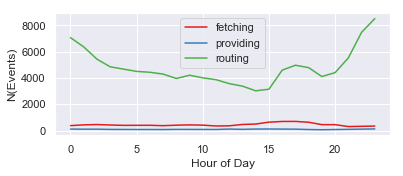

In [258]:
# Operations per hour for all VPs
ops_by_hour = dfTimeseries.groupby(
    [dfTimeseries.index.hour, 'OpCategory']
)['OpCategory'].size().rename('count').reset_index()

ops_by_hour['Avg Hourly Ops'] = ops_by_hour['count'] / 14

# Plot
sns.set(rc={'figure.figsize':(6,2.25)})
ax = sns.lineplot(data=ops_by_hour, 
             x='dti',y='Avg Hourly Ops', 
             hue='OpCategory', palette=sns.color_palette("Set1", 3),
             estimator=None, markers=True)

# Labels
ax.set(xlabel="Hour of Day", ylabel="N(Events)")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

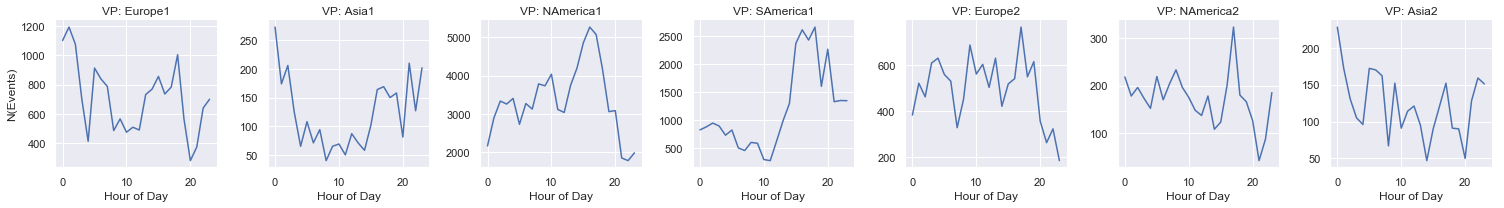

In [212]:
# File-related events per hour by VP location
fetches = dfTimeseries[ dfTimeseries.OpCategory == 'fetching' ]
fetches = fetches.groupby(  [fetches.index.hour, 'OpCategory', 'VP_SHORT'] ).size().rename('count').reset_index()
fetches['VP'] = fetches.VP_SHORT.map({'ams': "Europe1", 'bom': "Asia1", 'chs': 'NAmerica1', 'gru': "SAmerica1", 'hel': "Europe2", "lax": "NAmerica2", "sin": "Asia2"})

# Plot
g = sns.FacetGrid(data=fetches, col='VP',  hue='OpCategory', sharey=False)
g.map(sns.lineplot, 'dti', 'count', estimator=None).set_axis_labels("Hour of Day", "N(Events)").set_titles("VP: {col_name}")


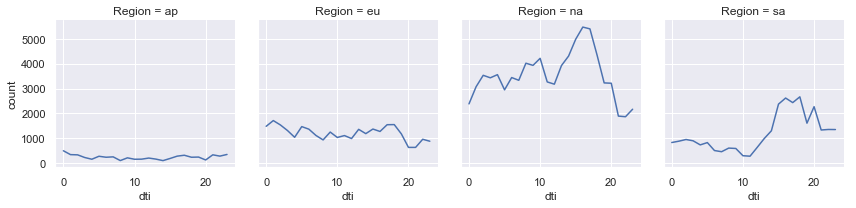

In [8]:
# File-related events per hour by VP region

fetches = dfTimeseries[ dfTimeseries.OpCategory == 'fetching' ]
fetches = fetches.groupby(  [fetches.index.hour, 'OpCategory', 'Region'] ).size().rename('count').reset_index()
g = sns.FacetGrid(data=fetches, col='Region',  hue='OpCategory')
g.map(sns.lineplot, 'dti', 'count')


# 2. Timeseries of cumulative activity

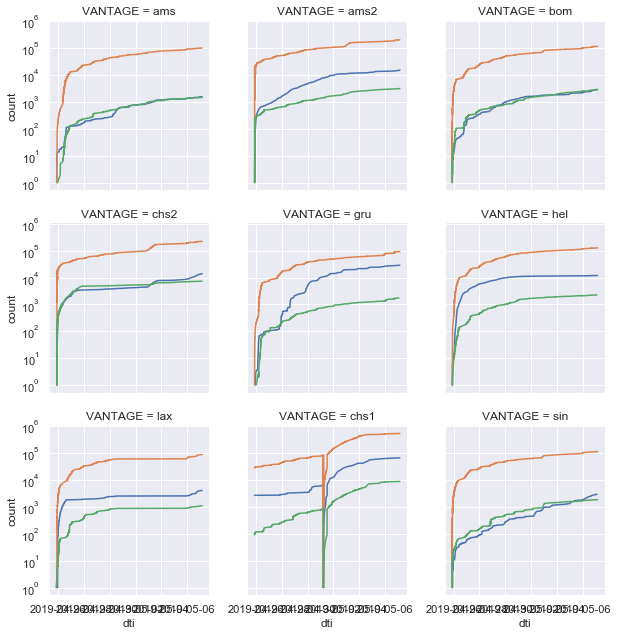

In [278]:
# Cumulative count of operations per VP location
dfTimeseries['count'] = dfTimeseries.groupby(['VANTAGE','OpCategory']).cumcount()+1

g = sns.FacetGrid(data=dfTimeseries, col='VANTAGE', col_wrap=3, hue='OpCategory')
g.map(sns.lineplot, 'dti', 'count', estimator=None, markers=True).set(yscale='log')

# The weird dip in chs1 is due to an unplanned restart of the VM

# 3. Histograms of hash mentions (content)

Text(0,0.5,'N(Hashes)')

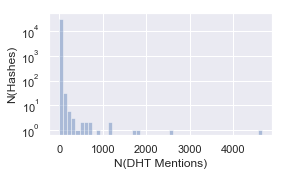

In [261]:
# Distribution of popularity of content
counts = dfTxns.Key.value_counts()
sns.set(rc={'figure.figsize':(4,2.25)})
ax = sns.distplot(counts, kde=False)

ax.set_yscale('log')
ax.set_xlabel("N(DHT Mentions)")
ax.set_ylabel("N(Hashes)")

# 4. Op durations

In [265]:
# New subset of timeseries data to probe event duration
subset = dfTimeseries[ ['Operation', 'OpCategory', 'Duration', 'VANTAGE', 'VP_SHORT', 'Region'] ]
subset['Duration'] = subset['Duration'] / 1e5 # millis

/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


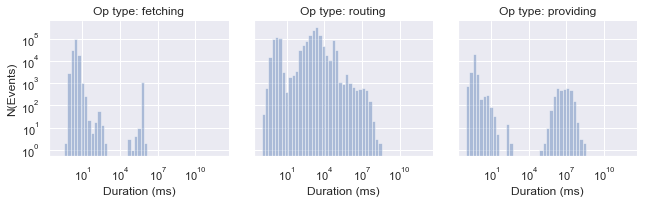

In [266]:
# Plot
g = sns.FacetGrid(data=subset, col='OpCategory').set(yscale='log', xscale='log')
g.map(sns.distplot, 'Duration', kde=False, bins=np.logspace(np.log10(0.1),np.log10(1e12), 50)).set_axis_labels("Duration (ms)", "N(Events)").set_titles("Op type: {col_name}")

In [193]:
# Top 5%, bottom 5% sample of DHT hashes for scraping
top = dfTxns.Key.value_counts().reset_index()
top.columns = ["Hash", "Count"]
top5 = top[ top.Count >= top.Count.quantile(0.95) ]
bottom5 = top[ top.Count <= top.Count.quantile(0.05) ]
topsample, bottomsample = top5.sample(500), bottom5.sample(500)
topsample.append(bottomsample).Hash.to_csv("Sampled_Hashes.csv")

In [118]:
# Co-occurrence matrix of DHT hashes: how many hashes showed up at multiple VPs
counts = pd.DataFrame(dfTxns.groupby('VANTAGE').Key.value_counts())
counts.columns = ['N']
counts = counts.reset_index()
counts.columns = ['Vantage', 'Hash', 'N']

# Sloppy use of dictionaries and sets of hashes to create this... 
# I'm sure there's a better way in pandas :)
vps = sorted(list(set(counts.Vantage)))
sets = {vp: set(counts[ counts.Vantage == vp ].Hash) for vp in vps}

# Which hashes showed up in which VP?
results = {
    vp: {vp2: [] for vp2 in vps} for vp in vps
}
# How many hashes showed up in each VP?
lens = {
    vp: {vp2: np.nan for vp2 in vps} for vp in vps
}
# Finally a flat list of hashes for scraping
flat = set()

# Iterate over vp X vp, add and update counts
for vp1 in vps:
    for vp2 in vps:
        if vp1 != vp2:
            overlap = sets[vp1] & sets[vp2]
            results[vp1][vp2] = list(overlap)
            lens[vp1][vp2] = len(overlap)
            flat.update( overlap )

[Text(0,0.5,'N(seen at multiple VPs)'), Text(0.5,0,'Popularity rank')]

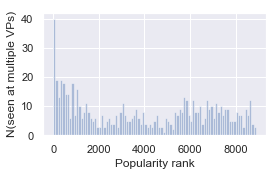

In [276]:
# Plot number of co-occurrences based on popularity rank (times seen) across all VPs
top['CoOccurs'] = top.Hash.apply(lambda h: h in flat)
ax = sns.distplot( top[ top.CoOccurs == True ].index, bins=np.arange(0, 9000, 100), kde=False )
ax.set(xlabel="Popularity rank", ylabel="N(seen at multiple VPs)")

In [196]:
# Load results of hash scraping
with open("DHT_Hashes/Hash_Results2.json") as f:
    hashdata1 = json.load(f)

with open("DHT_Hashes/CoHash_Results2.json") as f:
    hashdata2 = json.load(f)

# Get info on files scraped and timeouts 
stats = pd.DataFrame(hashdata1['results'] + hashdata2['results'])
timeouts = list(set( hashdata1['timeouts'] + hashdata2['timeouts']) )
top['TimedOut'] = top.Hash.apply(lambda h: h in hashdata['timeouts'])
top = top.merge(stats, how='outer', on='Hash')


In [320]:
stats.head()

,BlockSize,Code,CumulativeSize,DataSize,Hash,LinksSize,Message,NumLinks,Type
0,262158.0,NaN,262158.0,262154.0,QmdBzucSjGDaU647kJS4693rHFV4gpKD8AyN9MoFy6rBD2,4.0,NaN,0.0,NaN
1,262158.0,NaN,262158.0,262154.0,QmW6P8mFC3RwrVMiManRCcG5phh2Gddi28od6KyBtWgd21,4.0,NaN,0.0,NaN
2,109.0,NaN,66802699.0,17.0,QmZ4wn2xTvkMUrcnsyS1GdZkejTdToKYwLnjZV4NnZczNv,92.0,NaN,2.0,NaN
3,262158.0,NaN,262158.0,262154.0,QmbEP6Rov3Uyy8SuAvDHje5E6Vo1qcn9LSX6nAxhW8T5eC,4.0,NaN,0.0,NaN
4,296.0,NaN,1393460.0,30.0,Qmeejs9fvYdyMHu3ahdj611kX62wkMRFhFuZju3GjCDC8E,266.0,NaN,6.0,NaN


[None]

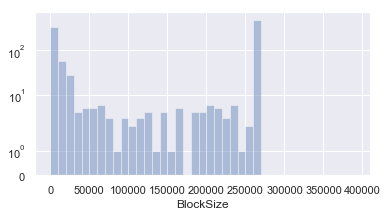

In [318]:
# Distribution of block sizes
stats.CumulativeSize.value_counts(normalize=True).head()

In [306]:
len(timeouts)

686

[None]

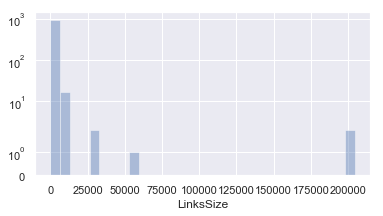

In [323]:
sns.distplot(stats.LinksSize.fillna(0), kde=False).set(yscale='symlog')

In [297]:
# Breakdown of events by VP
dfTimeseries.VANTAGE.value_counts(normalize=True)

chs1    0.345566
chs2    0.135418
ams2    0.124360
hel     0.079098
gru     0.068732
bom     0.068390
sin     0.067292
ams     0.058556
lax     0.052587
Name: VANTAGE, dtype: float64

In [300]:
# Events by type
dfTimeseries.OpCategory.value_counts()

routing      1613199
fetching      148762
providing      30734
Name: OpCategory, dtype: int64